#Setup

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

UsageError: Cell magic `%%shell` not found.


In [2]:
%pip install -Uq pysr pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [3]:
from julia import Julia

julia = Julia(compiled_modules=False, threads='auto')
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

FileNotFoundError: [Errno 2] No such file or directory: 'julia'

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.2 LTS
  uname: Linux 5.15.120+ #1 SMP Wed Aug 30 11:19:59 UTC 2023 x86_64 x86_64
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz: 
              speed         user         nice          sys         idle          irq
       #1  2199 MHz       1098 s          0 s        187 s        887 s          0 s
       #2  2199 MHz       1041 s          0 s        198 s        908 s          0 s
  Memory: 12.6783447265625 GB (11653.50390625 MB free)
  Uptime: 224.16 sec
  Load Avg:  2.66  1.22  0.49
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 1 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_PROJECT = @pysr-0.16.3
  JULIA_PKG_PRECOMPILE_AUTO = 0
  TCLLIBPATH = /usr/share/tcltk/tcllib1.20
  HOME = /root
  PYTHONPATH = /env/python
  LIBRARY_PATH = /usr/local/cuda/lib64/stubs
  PATH =

[ Info: Julia version info
[ Info: Julia executable: /usr/local/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /usr/bin/python3
│     libpython: /usr/lib/x86_64-linux-gnu/libpython3.10.so.1.0
│ Python:
│     python: /usr/bin/python3
└     libpython: 
    Updating registry at `~/.julia/registries/General.toml`
     Cloning git-repo `https://github.com/MilesCranmer/SymbolicRegression.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Tricks ─────────────────────────── v0.1.7
   Installed IrrationalConstants ────────────── v0.2.2
   Installed ScientificTypesBase ────────────── v3.0.0
   Installed SIMDTypes ──────────────────────── v0.1.0
   Installed BitTwiddlingConvenienceFunctions ─ v0.1.5
   Installed DynamicExpressions ─────────────── v0.13.1
   Installed DiffRules ──────────────────────── v1.15.1
   Installed Adapt ────────────

In [ ]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

#Introduction
To start the project first I am going to see to what extent PySR is capable by varying:
- seed
- error
- number of points


Let´s start with the function
$$ f(x)=113 \cdot e^{-2(x-1)^2 }$$
in which each point has a poisson distribution with average value $f(x)$


In [ ]:
np.random.seed(0)
n = 3000
X = 6 * np.random.rand(n,2)-3
H = 113 * np.exp(-2 * (X[:, 0]-1) * (X[:, 0]-1))
y = np.random.poisson(H, n)

Let's vizualize our dataset:

Text(0, 0.5, '$y$')

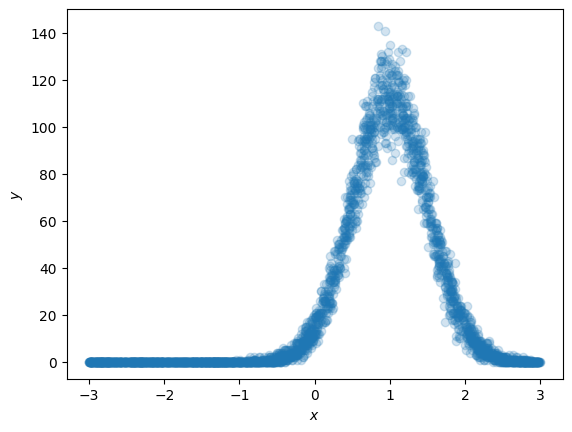

In [ ]:
plt.scatter(X[:,0], y, alpha=0.2)
plt.xlabel("$x$")
plt.ylabel("$y$")

Starting our symbolic regression algorithm...

In [ ]:
model = PySRRegressor(
    niterations=5,
    populations=100,
    binary_operators=["plus", "mult"],
    unary_operators=["exp"],
)
model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:231: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(


Started!

Expressions evaluated per second: 4.650e+02
Head worker occupation: 0.6%
Progress: 5 / 500 total iterations (1.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.838e+03  1.594e+01  y = 1.9397
2           1.585e+03  1.481e-01  y = exp(2.1858)
3           1.383e+03  1.364e-01  y = exp(exp(1.0946))
5           1.338e+03  1.665e-02  y = (x₀ + exp(exp(1.0946)))
7           1.298e+03  1.520e-02  y = ((x₀ * 2.0233) + exp(exp(1.0946)))
8           1.191e+03  8.530e-02  y = ((x₀ * exp(2.0233)) + exp(exp(1.0946)))
10          1.183e+03  3.731e-03  y = (x₀ + (((exp(2.1684) + x₀) + x₀) * 2.7263))
11          1.176e+03  5.220e-03  y = (((x₀ * exp(2.0233)) + exp(exp(1.0946))) + exp(1.5023))
12          1.176e+03  4.289e-04  y = (-0.49109 + ((((exp(2.1684) + x₀) + x₀) + x₀) * 2.7263))
13          1.140e+03  3.118e-02  y = ((x₀ * exp(2.0233 + (-0.23519 * exp(x₀)))) + 

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                          23.600122   
	1        7.306075e-08                                     exp(3.1611931)   
	2        3.376693e-02                                   (23.625639 + x0)   
	3        5.917130e-02                     ((2.9841547 + x0) * 7.9653964)   
	4        3.788381e-02        (exp(x0 * exp(-1.8586218 * x0)) * 23.60523)   
	5        1.892438e+00  exp(x0 * exp(2.5355692 + (-0.3509441 * exp(x0))))   
	6        2.250440e-01  exp((x0 * exp(2.280148 + (-0.33802694 * exp(x0...   
	7        8.854097e-02  ((exp(x0 * exp(2.0232666 + (-0.33802694 * exp(...   
	8  >>>>  2.749724e-01  (exp(x0 * exp(2.092371 + (-0.33802694 * (exp(x...   
	9        8.427256e-02  ((exp((x0 * exp(2.0232666 + (-0.33802694 * exp...   
	
	          loss  complexity  
	0  1368.724100           1  
	1  1368.724000           2  
	2  1323.278000           3  
	3  1175.589100           5  
	4  1010.286700           9  
	5   152.254260          10  
	6    97.073050          12  
	7    81.319176          14  
	8    61.769485          15  
	9    44.093803          19  
]

In [ ]:
model.sympy()

8.10410724137608*exp(6.70557039622549*x0*exp(-0.33802694*exp(x0)))

We can see that the equation of our regression looks nothing like the one we started with.

Two ideas follow:
- Increasing the complexity of the exponential operator;
- Increasing the number of points of our dataset;

This is a problem that has nothing to do with the seed nor with the error, as PySR is perfecly cpable of handling with a Poisson distribution.

Still, we can see that the curve adjusts somewhat well to our dataset. The only thing is that the expression is much uglier than the one we wanted to find.

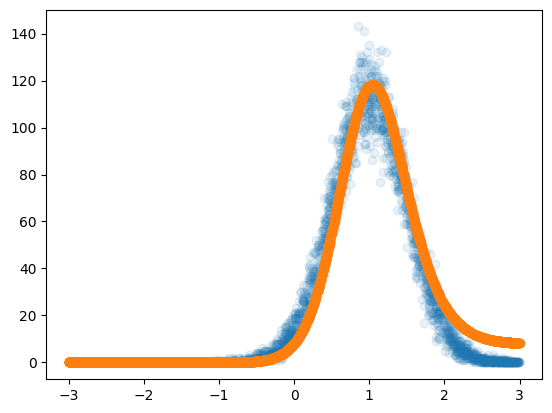

In [ ]:
best_idx = model.equations_.query(
    f"loss < {2 * model.equations_.loss.min()}"
).score.idxmax()
model.sympy(best_idx)
plt.scatter(X[:, 0], y, alpha=0.1)
y_prediction = model.predict(X, index=best_idx)
plt.scatter(X[:, 0], y_prediction)

So let´s do the same thing, with another seed, but now with double the points in the dataset:

In [ ]:
np.random.seed(1)
n = 6000
X = 6 * np.random.rand(n,2)-3
H = 113 * np.exp(-2 * X[:, 0] * X[:, 0])
y = np.random.poisson(H, n)

model = PySRRegressor(
    niterations=5,
    populations=100,
    binary_operators=["plus", "mult"],
    unary_operators=["exp"],
)
model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:231: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(


Started!

Expressions evaluated per second: 1.410e+03
Head worker occupation: NaN%
Progress: 2 / 500 total iterations (0.400%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.910e+03  1.594e+01  y = 1.4586
2           1.789e+03  6.550e-02  y = exp(1.4586)
4           1.437e+03  1.094e-01  y = exp(1.4586 + 1.4073)
6           1.431e+03  2.299e-03  y = (exp(1.4586 + 1.4073) + 0.51824)
7           1.400e+03  2.128e-02  y = exp((1.4586 + exp(-0.85678)) + 1.4073)
10          1.394e+03  1.642e-03  y = exp((0.74176 + exp(exp(0.28098 + -0.93523))) + 0.74176)
11          1.393e+03  6.402e-05  y = (exp(((1.4586 + exp(-0.85678)) + 1.4073) + -0.24039) * 1.1...
                                  638)
12          1.393e+03  1.056e-04  y = exp((0.74176 + (exp(0.28098 + -0.93523) + exp(0.16532))) +...
                                   0.74176)
13          1.354e+03  2.837e-02  y = 

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          24.184612   
	1         1.435414e-07                                      exp(3.185921)   
	2         6.242244e-05                    (24.185198 + (0.29297605 * x1))   
	3         8.201357e-02               (-2.289184 * (-12.306413 + exp(x0)))   
	4         1.467197e-01            (-2.5216415 * (-12.306413 + (x0 * x0)))   
	5         7.604789e-01     exp(exp(1.4465126) + (-1.1994683 * (x0 * x0)))   
	6         1.779908e+00  exp(exp(exp(x0 * (-0.37158972 * x0)) * 1.56152...   
	7   >>>>  5.310924e-01  exp((exp(1.1682842) + ((x0 * -1.987952) * x0))...   
	8         1.409709e-05  exp((exp(0.7853394) + ((x0 * -1.9917324) * x0)...   
	9         2.036548e-05  (exp((exp(1.1682842) + ((x0 * -1.987952) * (x0...   
	10        4.294097e-05  (exp((exp(0.7853394) + ((x0 * -1.9917324) * x0...   
	11        3.088563e-05  (exp((exp(0.7853394) + ((x0 * -1.9917324) * x0...   
	
	           loss  complexity  
	0   1393.326200           1  
	1   1393.326000           2  
	2   1393.065100           5  
	3   1283.374400           6  
	4   1108.240000           7  
	5    242.153240           9  
	6     40.840015          10  
	7     24.012390          11  
	8     24.011713          13  
	9     24.010735          15  
	10    24.008673          17  
	11    24.007190          19  
]

In [ ]:
model.sympy()

112.983081195866*exp(-1.987952*x0**2)

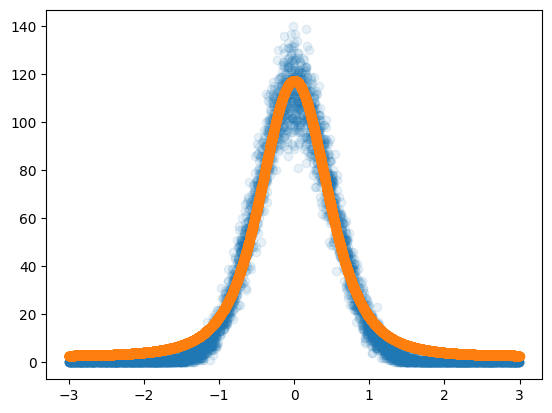

In [ ]:
best_idx = model.equations_.query(
    f"loss < {2 * model.equations_.loss.min()}"
).score.idxmax()
model.sympy(best_idx)
plt.scatter(X[:, 0], y, alpha=0.1)
y_prediction = model.predict(X, index=best_idx)
plt.scatter(X[:, 0], y_prediction)

The problem appears to be the same. Now let´s test with the same dataset but increasing the exponential's complexity.

In [ ]:
model = PySRRegressor(
    niterations=5,
    populations=100,
    binary_operators=["plus", "mult"],
    unary_operators=["exp"],
    complexity_of_operators={"exp": 2},
)
model.fit(X, y)

In [ ]:
model.sympy()

In [ ]:
best_idx = model.equations_.query(
    f"loss < {2 * model.equations_.loss.min()}"
).score.idxmax()
model.sympy(best_idx)
plt.scatter(X[:, 0], y, alpha=0.1)
y_prediction = model.predict(X, index=best_idx)
plt.scatter(X[:, 0], y_prediction)